<a href="https://colab.research.google.com/github/amshabaeva/NN_methods/blob/main/hw3_Shabaeva_rnn.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## Домашнее задание №3

#### Настя Шабаева, БКЛ181

###  Импорт всего необходимого

In [ ]:
!pip install ipdb

     |████████████████████████████████| 791 kB 14.2 MB/s 
     |████████████████████████████████| 374 kB 46.6 MB/s 
  Created wheel for ipdb: filename=ipdb-0.13.9-py3-none-any.whl size=11648 sha256=808e1f08812b8b2b984adb864793e06aa3fbb25dc2e6c2db0856f300e1115422
  Stored in directory: /root/.cache/pip/wheels/65/cd/cc/aaf92acae337a28fdd2aa4d632196a59745c8c39f76eaeed01
Successfully built ipdb
  Attempting uninstall: prompt-toolkit
    Found existing installation: prompt-toolkit 1.0.18
    Uninstalling prompt-toolkit-1.0.18:
      Successfully uninstalled prompt-toolkit-1.0.18
  Attempting uninstall: ipython
    Found existing installation: ipython 5.5.0
    Uninstalling ipython-5.5.0:
      Successfully uninstalled ipython-5.5.0
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
jupyter-console 5.2.0 requires prompt-toolkit<2.0.0,>=1.0.0, but you have prompt-toolkit

In [ ]:
!pip install torchmetrics

     |████████████████████████████████| 332 kB 7.4 MB/s 


In [ ]:
import pandas as pd
import numpy as np
from string import punctuation
from collections import Counter
import re
from sklearn.model_selection import train_test_split
from sklearn.utils import shuffle
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader, RandomSampler, SequentialSampler
from torch.nn.utils.rnn import pad_sequence
import torch.optim as optim
import ipdb
import torchmetrics
from torchmetrics import F1
from torchmetrics.functional import f1, recall, precision, accuracy
import seaborn as sns
import matplotlib.pyplot as plt
import gensim
from statistics import mean

### Данные

Датасет Fake.csv с сайта https://www.kaggle.com/clmentbisaillon/fake-and-real-news-dataset?select=Fake.csv .
Помещаем данные в датафрейм.

In [ ]:
fake_news = pd.read_csv('Fake.csv', encoding='utf-8', header=0, names=['title','text','subject','date'])
fake_news

,title,text,subject,date
0,Donald Trump Sends Out Embarrassing New Year’...,Donald Trump just couldn t wish all Americans ...,News,"December 31, 2017"
1,Drunk Bragging Trump Staffer Started Russian ...,House Intelligence Committee Chairman Devin Nu...,News,"December 31, 2017"
2,Sheriff David Clarke Becomes An Internet Joke...,"On Friday, it was revealed that former Milwauk...",News,"December 30, 2017"
3,Trump Is So Obsessed He Even Has Obama’s Name...,"On Christmas day, Donald Trump announced that ...",News,"December 29, 2017"
4,Pope Francis Just Called Out Donald Trump Dur...,Pope Francis used his annual Christmas Day mes...,News,"December 25, 2017"
...,...,...,...,...
23476,McPain: John McCain Furious That Iran Treated ...,21st Century Wire says As 21WIRE reported earl...,Middle-east,"January 16, 2016"
23477,JUSTICE? Yahoo Settles E-mail Privacy Class-ac...,21st Century Wire says It s a familiar theme. ...,Middle-east,"January 16, 2016"
23478,Sunnistan: US and Allied ‘Safe Zone’ Plan to T...,Patrick Henningsen 21st Century WireRemember ...,Middle-east,"January 15, 2016"
23479,How to Blow $700 Million: Al Jazeera America F...,21st Century Wire says Al Jazeera America will...,Middle-east,"January 14, 2016"


### Предобработка

Заменим названия категорий (subject) на порядковые номера. Сначала создадим словарь, в котором каждому значению из колонки subject будет соответствовать номер, а затем создадим отдельную колонку уже с номерами вместо текстовых занчений subject

In [ ]:
classification = dict.fromkeys(set(fake_news['subject']))

classification

{'Government News': None,
 'Middle-east': None,
 'News': None,
 'US_News': None,
 'left-news': None,
 'politics': None}

In [ ]:
classification['US_News'] = 0
classification['News'] = 1
classification['left-news'] = 2
classification['Government News'] = 3
classification['Middle-east'] = 4
classification['politics'] = 5

classification

{'Government News': 3,
 'Middle-east': 4,
 'News': 1,
 'US_News': 0,
 'left-news': 2,
 'politics': 5}

In [ ]:
fake_news['classification'] = [classification[row.subject] for row in fake_news.itertuples()]

In [ ]:
fake_news

,title,text,subject,date,classification
0,Donald Trump Sends Out Embarrassing New Year’...,Donald Trump just couldn t wish all Americans ...,News,"December 31, 2017",1
1,Drunk Bragging Trump Staffer Started Russian ...,House Intelligence Committee Chairman Devin Nu...,News,"December 31, 2017",1
2,Sheriff David Clarke Becomes An Internet Joke...,"On Friday, it was revealed that former Milwauk...",News,"December 30, 2017",1
3,Trump Is So Obsessed He Even Has Obama’s Name...,"On Christmas day, Donald Trump announced that ...",News,"December 29, 2017",1
4,Pope Francis Just Called Out Donald Trump Dur...,Pope Francis used his annual Christmas Day mes...,News,"December 25, 2017",1
...,...,...,...,...,...
23476,McPain: John McCain Furious That Iran Treated ...,21st Century Wire says As 21WIRE reported earl...,Middle-east,"January 16, 2016",4
23477,JUSTICE? Yahoo Settles E-mail Privacy Class-ac...,21st Century Wire says It s a familiar theme. ...,Middle-east,"January 16, 2016",4
23478,Sunnistan: US and Allied ‘Safe Zone’ Plan to T...,Patrick Henningsen 21st Century WireRemember ...,Middle-east,"January 15, 2016",4
23479,How to Blow $700 Million: Al Jazeera America F...,21st Century Wire says Al Jazeera America will...,Middle-east,"January 14, 2016",4


Создадим отдельную колонку для "очищенного" текста

Функция простейшего препроцессинга текстов: делим твиты на токены, приводим к нижнему регистру и удаляем всю пунктуацию.

In [ ]:
def preprocess(text):
    tokens = text.lower().split()
    tokens = [token.strip(punctuation) for token in tokens]
    return tokens

In [ ]:
fake_news['preprocessed'] = [" ".join(preprocess(row.text)) for row in fake_news.itertuples()]

In [ ]:
fake_news

,title,text,subject,date,classification,preprocessed
0,Donald Trump Sends Out Embarrassing New Year’...,Donald Trump just couldn t wish all Americans ...,News,"December 31, 2017",1,donald trump just couldn t wish all americans ...
1,Drunk Bragging Trump Staffer Started Russian ...,House Intelligence Committee Chairman Devin Nu...,News,"December 31, 2017",1,house intelligence committee chairman devin nu...
2,Sheriff David Clarke Becomes An Internet Joke...,"On Friday, it was revealed that former Milwauk...",News,"December 30, 2017",1,on friday it was revealed that former milwauke...
3,Trump Is So Obsessed He Even Has Obama’s Name...,"On Christmas day, Donald Trump announced that ...",News,"December 29, 2017",1,on christmas day donald trump announced that h...
4,Pope Francis Just Called Out Donald Trump Dur...,Pope Francis used his annual Christmas Day mes...,News,"December 25, 2017",1,pope francis used his annual christmas day mes...
...,...,...,...,...,...,...
23476,McPain: John McCain Furious That Iran Treated ...,21st Century Wire says As 21WIRE reported earl...,Middle-east,"January 16, 2016",4,21st century wire says as 21wire reported earl...
23477,JUSTICE? Yahoo Settles E-mail Privacy Class-ac...,21st Century Wire says It s a familiar theme. ...,Middle-east,"January 16, 2016",4,21st century wire says it s a familiar theme w...
23478,Sunnistan: US and Allied ‘Safe Zone’ Plan to T...,Patrick Henningsen 21st Century WireRemember ...,Middle-east,"January 15, 2016",4,patrick henningsen 21st century wireremember w...
23479,How to Blow $700 Million: Al Jazeera America F...,21st Century Wire says Al Jazeera America will...,Middle-east,"January 14, 2016",4,21st century wire says al jazeera america will...


### Микро анализ данных

Посмотрим распределение длин текстов, чтобы понять, как делать паддинг

In [ ]:
fake_news['len'] = [len(preprocess(row.text)) for row in fake_news.itertuples()]
fake_news

,title,text,subject,date,classification,preprocessed,len
0,Donald Trump Sends Out Embarrassing New Year’...,Donald Trump just couldn t wish all Americans ...,News,"December 31, 2017",1,donald trump just couldn t wish all americans ...,495
1,Drunk Bragging Trump Staffer Started Russian ...,House Intelligence Committee Chairman Devin Nu...,News,"December 31, 2017",1,house intelligence committee chairman devin nu...,305
2,Sheriff David Clarke Becomes An Internet Joke...,"On Friday, it was revealed that former Milwauk...",News,"December 30, 2017",1,on friday it was revealed that former milwauke...,580
3,Trump Is So Obsessed He Even Has Obama’s Name...,"On Christmas day, Donald Trump announced that ...",News,"December 29, 2017",1,on christmas day donald trump announced that h...,444
4,Pope Francis Just Called Out Donald Trump Dur...,Pope Francis used his annual Christmas Day mes...,News,"December 25, 2017",1,pope francis used his annual christmas day mes...,420
...,...,...,...,...,...,...,...
23476,McPain: John McCain Furious That Iran Treated ...,21st Century Wire says As 21WIRE reported earl...,Middle-east,"January 16, 2016",4,21st century wire says as 21wire reported earl...,522
23477,JUSTICE? Yahoo Settles E-mail Privacy Class-ac...,21st Century Wire says It s a familiar theme. ...,Middle-east,"January 16, 2016",4,21st century wire says it s a familiar theme w...,297
23478,Sunnistan: US and Allied ‘Safe Zone’ Plan to T...,Patrick Henningsen 21st Century WireRemember ...,Middle-east,"January 15, 2016",4,patrick henningsen 21st century wireremember w...,4171
23479,How to Blow $700 Million: Al Jazeera America F...,21st Century Wire says Al Jazeera America will...,Middle-east,"January 14, 2016",4,21st century wire says al jazeera america will...,456


Можно заметить, что текстов, в которых больше 1000 слов, очень мало, попробую их выбросить

In [ ]:
fig1 = fake_news['len'].hist()
hist1 = fig1.get_figure()
plt.close()

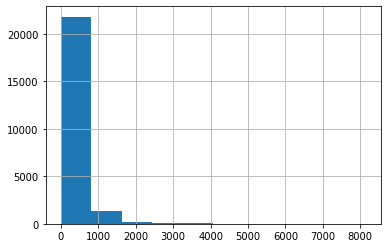

In [ ]:
hist1

In [ ]:
fake_news = fake_news.loc[fake_news['len'] <= 1000]

fake_news

,title,text,subject,date,classification,preprocessed,len
0,Donald Trump Sends Out Embarrassing New Year’...,Donald Trump just couldn t wish all Americans ...,News,"December 31, 2017",1,donald trump just couldn t wish all americans ...,495
1,Drunk Bragging Trump Staffer Started Russian ...,House Intelligence Committee Chairman Devin Nu...,News,"December 31, 2017",1,house intelligence committee chairman devin nu...,305
2,Sheriff David Clarke Becomes An Internet Joke...,"On Friday, it was revealed that former Milwauk...",News,"December 30, 2017",1,on friday it was revealed that former milwauke...,580
3,Trump Is So Obsessed He Even Has Obama’s Name...,"On Christmas day, Donald Trump announced that ...",News,"December 29, 2017",1,on christmas day donald trump announced that h...,444
4,Pope Francis Just Called Out Donald Trump Dur...,Pope Francis used his annual Christmas Day mes...,News,"December 25, 2017",1,pope francis used his annual christmas day mes...,420
...,...,...,...,...,...,...,...
23475,Hillary Clinton: ‘Israel First’ (and no peace ...,Robert Fantina CounterpunchAlthough the United...,Middle-east,"January 18, 2016",4,robert fantina counterpunchalthough the united...,767
23476,McPain: John McCain Furious That Iran Treated ...,21st Century Wire says As 21WIRE reported earl...,Middle-east,"January 16, 2016",4,21st century wire says as 21wire reported earl...,522
23477,JUSTICE? Yahoo Settles E-mail Privacy Class-ac...,21st Century Wire says It s a familiar theme. ...,Middle-east,"January 16, 2016",4,21st century wire says it s a familiar theme w...,297
23479,How to Blow $700 Million: Al Jazeera America F...,21st Century Wire says Al Jazeera America will...,Middle-east,"January 14, 2016",4,21st century wire says al jazeera america will...,456


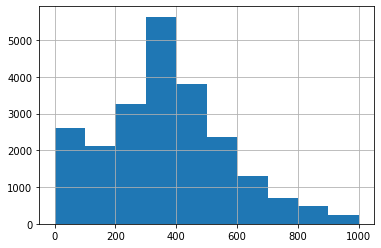

In [ ]:
fig2 = fake_news['len'].hist()
hist2 = fig2.get_figure()
plt.close()
hist2

#### Максимальная длина текста

In [ ]:
max_len = max(list(fake_news['len']))

max_len

1000

Я убрала из датасета все тексты, длина которых больше 1000 (их оказалось всего около 1000 штук. Теперь максимальная длина текста - 1000 слов

### Делим на обучающую и тестовую выборки

С соотношением 9 к 1

In [ ]:
train_news, val_news = train_test_split(fake_news, test_size=0.1)

In [ ]:
train_news

,title,text,subject,date,classification,preprocessed,len
4108,WATCH: Carol Costello HUMILIATES Trump Suppor...,CNN host Carol Costello was so fed up with a T...,News,"October 20, 2016",1,cnn host carol costello was so fed up with a t...,484
4646,Leave It To Obama To ROAST Trump For Saying H...,"If you haven t noticed, Donald Trump isn t qui...",News,"September 13, 2016",1,if you haven t noticed donald trump isn t quit...,297
16080,BOOM! TREY GOWDY Hammers Ex-CIA Chief [Video],Trey Gowdy asked a pointed question of former ...,Government News,"May 23, 2017",3,trey gowdy asked a pointed question of former ...,254
6130,A High School Student Just Bashed ‘You Deserv...,"For years, a street preacher has been embarras...",News,"May 28, 2016",1,for years a street preacher has been embarrass...,577
1094,Arizona Republican Says College Kids Make Ele...,It s an old story: A demographic won t vote Re...,News,"June 18, 2017",1,it s an old story a demographic won t vote rep...,450
...,...,...,...,...,...,...,...
6875,"Bill Maher: Tax The Churches, Why Are We Payi...",It s no secret that the comedic host of HBO s ...,News,"April 16, 2016",1,it s no secret that the comedic host of hbo s ...,415
8269,Hillary Gives Rubio A New Name After He Says ...,Marco Rubio is making a name for himself in th...,News,"February 7, 2016",1,marco rubio is making a name for himself in th...,417
20577,UPDATE: 12 STATES NOW Giving Obama Middle Fing...,Only 38 states to go. Obama is going to do mor...,left-news,"May 13, 2016",2,only 38 states to go obama is going to do more...,421
17645,WOW! WATCH: CREEPY JOE BIDEN Just Can’t Keep H...,"Yesterday, we posted videos of Creepy Joe Bid...",left-news,"Nov 15, 2017",2,yesterday we posted videos of creepy joe biden...,625


### Word2id, Id2word и device

Создаем словарь уникальных токенов, а потом оставляем только те токены, которые встретились больше 5 раз

In [ ]:
vocab = Counter()

for text in fake_news['text']:
    vocab.update(preprocess(text))
print('всего уникальных токенов:', len(vocab))

всего уникальных токенов: 175378


In [ ]:
filtered_vocab = set()

for word in vocab:
    if vocab[word] > 5:
        filtered_vocab.add(word)
print('уникальных токенов, втретившихся больше 5 раз:', len(filtered_vocab))

уникальных токенов, втретившихся больше 5 раз: 31754


Создаем словарь, в ключах которого токены (встретившиеся больше 2 раз), в значениях их индексы в словаре word2id, для спецсимвола паддинга дефолтный индекс - 0

In [ ]:
word2id = {'PAD':0}

for word in filtered_vocab:
    word2id[word] = len(word2id)

Создаем обратный словарь id2word

In [ ]:
id2word = {i:word for word, i in word2id.items()}

Если возможно, просим торч использовать gpu.

In [ ]:
DEVICE = torch.device('cuda') if torch.cuda.is_available() else torch.device('cpu')
DEVICE

device(type='cuda')

### К самой архитектуре

#### Приведение данных в вид, подходящий для "отправки" в нейросеть

In [ ]:
class NewsDataset(Dataset):

    def __init__(self, dataset, column, word2id, max_len, DEVICE):
        self.dataset = dataset[column].values
        self.word2id = word2id
        self.length = dataset.shape[0]
        self.max_len = max_len
        self.target = torch.Tensor(dataset['classification'].values)
        self.device = DEVICE

    def __len__(self): #это обязательный метод, он должен уметь считать длину датасета
        return self.length

    def __getitem__(self, index): #еще один обязательный метод. По индексу возвращает элемент выборки
        tokens = self.dataset[index].split()
        ids = torch.LongTensor([self.word2id[token] if token in self.word2id else self.word2id['PAD'] for token in tokens][:self.max_len])
        y = [self.target[index]]
        return ids, y

    def collate_fn(self, batch): #этот метод можно реализовывать и отдельно,
    # он понадобится для DataLoader во время итерации по батчам
        ids, y = list(zip(*batch))
        padded_ids = torch.vstack([F.pad(seq, pad=(0, self.max_len - seq.shape[0]), mode='constant', value=0) for seq in ids])
        padded_ids = pad_sequence(ids, batch_first=True).to(self.device)
        y = torch.LongTensor(y).to(self.device)
        return padded_ids, y.T[0]

In [ ]:
train_dataset = NewsDataset(train_news, 'text', word2id, 400, DEVICE)
train_sampler = RandomSampler(train_dataset)
train_iterator = DataLoader(train_dataset, collate_fn = train_dataset.collate_fn, sampler=train_sampler, batch_size=64)

In [ ]:
val_dataset = NewsDataset(val_news, 'text', word2id, 400, DEVICE)
val_sampler = SequentialSampler(val_dataset)
val_iterator = DataLoader(val_dataset, collate_fn = val_dataset.collate_fn, sampler=val_sampler, batch_size=64)

#### Предобученные эмбеддинги

Как и в статье, я использовала вектора word2vec, насколько я поняла, предобученные на датасете Google News Dataset (http://code.google.com/p/word2vec/). Я скачивала "GoogleNews-vectors-negative300.bin.gz" с помощью wget (в ячейке ниже). 

Для неизвестных слов, как и в статье, создавался случайный вектор, с помощью равномерного распределения (промежуток [-0.25, 0.25])

In [ ]:
! wget -c "https://s3.amazonaws.com/dl4j-distribution/GoogleNews-vectors-negative300.bin.gz"

--2021-12-29 14:52:23--  https://s3.amazonaws.com/dl4j-distribution/GoogleNews-vectors-negative300.bin.gz
Resolving s3.amazonaws.com (s3.amazonaws.com)... 52.216.85.237
Connecting to s3.amazonaws.com (s3.amazonaws.com)|52.216.85.237|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 1647046227 (1.5G) [application/x-gzip]
Saving to: ‘GoogleNews-vectors-negative300.bin.gz’

GoogleNews-vectors- 100%[===================>]   1.53G  36.3MB/s    in 87s     

2021-12-29 14:53:50 (18.1 MB/s) - ‘GoogleNews-vectors-negative300.bin.gz’ saved [1647046227/1647046227]



In [ ]:
w2v = gensim.models.KeyedVectors.load_word2vec_format("GoogleNews-vectors-negative300.bin.gz", binary=True)
weights = np.zeros((len(word2id), 300))

for word, i in word2id.items():
    try:
        weights[i] = w2v[word]
    except KeyError:
        weights[i] = np.random.uniform(-0.25, 0.25, 300)

weights = torch.FloatTensor(weights).to(DEVICE)

#### Модель

In [ ]:
class C_LSTM(nn.Module):
    
    def __init__(self, vocab_size, max_len, embedding_dim=300, kernel_size_list=[2, 3, 4], dropout=0.5, dropout_emb=False, dropout_lstm=True):
        
        super().__init__()          
        # указываем в атрибутах класса, какие слои и активации нам понадобятся
        self.embedding = nn.Embedding(vocab_size, embedding_dim)
        self.embedding.from_pretrained(torch.tensor(weights), freeze=False)
        
        # для того, чтобы можно было создавать сверточные слои с разными шагами фильтров
        self.kernel_size_list = kernel_size_list
        conv_layers_list = []  # чтобы была возможность создавать несколько сверточных слоев
        for kernel in kernel_size_list:
            conv_layer = nn.Conv1d(in_channels=embedding_dim, out_channels=150, kernel_size=kernel, padding='valid')
            conv_layers_list.append(conv_layer)  # список со всеми сверточными слоями, что будут
        self.conv_layers = nn.ModuleList(conv_layers_list)
        
        self.lstm = nn.LSTM(input_size=len(kernel_size_list)*150, hidden_size=150, num_layers=1, batch_first=True)
        
        self.dim_len = max_len - max(kernel_size_list) + 1  # после сверточных слоев
        self.relu = nn.ReLU()
        self.hidden = nn.Linear(in_features=150, out_features=6)
        self.dropout = nn.Dropout(p=dropout)
        # это параметры для того, чтобы применять dropout можно было в разных местах
        self.dropout_emb = dropout_emb  # включаем или не включаем dropout после эмбеддинг слоя
        self.dropout_lstm = dropout_lstm  # включаем или не включаем dropout после lstm слоя
        self.out = nn.Softmax(dim=1)
        
        
    def forward(self, text): #необходимый метод,  в нем указываем, как именно связываются слои/активации между собой
        embedded = self.embedding(text)   # переводим последовательность индексов в последовательность эмбеддингов
        embedded = embedded.transpose(1,2)
        if self.dropout_emb:  # если решили делать дропаут после эмбеддинг слоя, делаем
            embedded = self.dropout(embedded)
        
        conv_outputs = []  # сверточные слои
        for conv_layer in self.conv_layers:
            layer = self.relu(conv_layer(embedded))[:, :, :self.dim_len]
            conv_outputs.append(layer)
              
        if len(self.kernel_size_list) > 1:  # готовим к lstm слою (конкатенация, если было несколько сверточных слоев)
            lstm_input = torch.cat(conv_outputs, 1).transpose(1, 2)
        else:
            lstm_input = layer.transpose(1, 2)
        
        _, (output, _) = self.lstm(lstm_input) # lstm
        
        if self.dropout_lstm:  # если решили делать дропаут после lstm слоя, делаем
            output = self.dropout(output)

        logits = self.out(self.hidden(torch.squeeze(output, 0)))      
        return logits

Создаем экземпляр модели

In [ ]:
model = C_LSTM(len(word2id), 400, dropout_lstm = False)
optimizer = torch.optim.RMSprop(model.parameters(), lr=0.001, weight_decay=0.0001)  # тут регуляризация
criterion = nn.CrossEntropyLoss()

model = model.to(DEVICE)
criterion = criterion.to(DEVICE)

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:8: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  


#### Функция обучения

In [ ]:
def train(model, iterator, optimizer, criterion):
    epoch_loss = 0 # для подсчета среднего лосса на всех батчах

    model.train()  # ставим модель в обучение, явно указываем, что сейчас надо будет хранить градиенты у всех весов

    for i, (texts, ys) in enumerate(iterator): #итерируемся по батчам
        optimizer.zero_grad()  #обнуляем градиенты
        preds = model(texts)  #прогоняем данные через модель
        loss = criterion(preds, ys) #считаем значение функции потерь  
        loss.backward() #считаем градиенты  
        optimizer.step() #обновляем веса 
        epoch_loss += loss.item() #сохраняем значение функции потерь
        if not (i + 1) % int(len(iterator)/5):
            print(f'Train loss: {epoch_loss/i}')      
    return  model, epoch_loss / len(iterator) # возвращаем среднее значение лосса по всей выборке

#### Функция эвалюации

In [ ]:
def evaluate(model, iterator, criterion):
    epoch_loss = 0
    epoch_metric_f1 = 0
    epoch_metric_precision = 0
    epoch_metric_recall = 0
    epoch_metric_accuracy = 0
    model.eval() 
    with torch.no_grad():
        for i, (texts, ys) in enumerate(iterator):   
            preds = model(texts)  # делаем предсказания на тесте
            loss = criterion(preds, ys)   # считаем значения функции ошибки для статистики  
            epoch_loss += loss.item()
            batch_metric_f1 = f1(preds.argmax(1).long(), ys.long(), ignore_index=0)
            epoch_metric_f1 += batch_metric_f1
            
            if not (i + 1) % int(len(iterator)/5):
                print(f'Val loss: {epoch_loss/i}, Val f1: {epoch_metric_f1/i}')
        
    return epoch_metric_f1 / len(iterator), epoch_loss / len(iterator)

#### Запускаем обучение и эвалюацию модели

На 10 эпохах

In [ ]:
losses = []
losses_eval = []
f1s = []
f1s_eval = []


for i in range(10):
    print(f'\nstarting Epoch {i}')
    print('Training...')
    model, epoch_loss = train(model, train_iterator, optimizer, criterion)
    losses.append(epoch_loss)
    print('\nEvaluating on train...')
    f1_on_train,_ = evaluate(model, train_iterator, criterion)
    f1s.append(f1_on_train)
    print('\nEvaluating on test...')
    f1_on_test, epoch_loss_on_test = evaluate(model, val_iterator, criterion)
    losses_eval.append(epoch_loss_on_test)
    f1s_eval.append(f1_on_test)


starting Epoch 0
Training...
Train loss: 1.6366747079357025
Train loss: 1.5885180406570434
Train loss: 1.561216856570954
Train loss: 1.540685552049918
Train loss: 1.5243264011516693

Evaluating on train...
Val loss: 1.4805237881598934, Val f1: 0.608434796333313
Val loss: 1.4658108768463134, Val f1: 0.60577791929245
Val loss: 1.4611729421514146, Val f1: 0.6040181517601013
Val loss: 1.4615878289439288, Val f1: 0.6015892028808594
Val loss: 1.4617922025121701, Val f1: 0.5994189977645874

Evaluating on test...
Val loss: 1.6939248442649841, Val f1: 0.7049479484558105
Val loss: 1.5705995284594023, Val f1: 0.6410039067268372
Val loss: 1.5325083017349244, Val f1: 0.62400883436203
Val loss: 1.514859331978692, Val f1: 0.6148666739463806
Val loss: 1.5136187321999495, Val f1: 0.6008079051971436

starting Epoch 1
Training...
Train loss: 1.480370952237037
Train loss: 1.4705567455291748
Train loss: 1.466114250269342
Train loss: 1.4620071749288248
Train loss: 1.459096838714211

Evaluating on train...


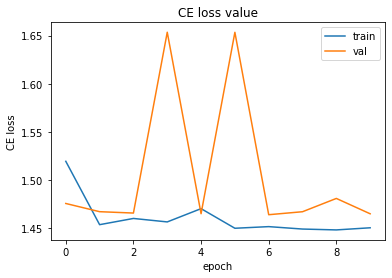

In [ ]:
plt.plot(losses)
plt.plot(losses_eval)
plt.title('CE loss value')
plt.ylabel('CE loss')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper right')
plt.show()

### Эксперименты

Теперь можно попробовать поэкспериментировать с разными параметрами. Например, с количеством свёрточных слоёв, разные шаги фильтров, добавить где-то дропаут (тоже попробовать добавлять в разных местах), поэкспериментировать с регуляризацией.

#### Для начала попробуем оставить 3 сверточных слоя и добавить дропаут после lstm слоя; а потом дропауты в в обоих местах (и после эмбеддинга и после lstm)

In [ ]:
model_1 = C_LSTM(len(word2id), 300)
optimizer_1 = torch.optim.RMSprop(model_1.parameters(), lr=0.001, weight_decay=0.0001)  # тут регуляризация
criterion = nn.CrossEntropyLoss()

model_1 = model_1.to(DEVICE)
criterion = criterion.to(DEVICE)

losses = []
losses_eval = []
f1s = []
f1s_eval_1 = []


for i in range(10):
    print(f'\nstarting Epoch {i}')
    print('Training...')
    model_1, epoch_loss = train(model_1, train_iterator, optimizer_1, criterion)
    losses.append(epoch_loss)
    print('\nEvaluating on train...')
    f1_on_train,_ = evaluate(model_1, train_iterator, criterion)
    f1s.append(f1_on_train)
    print('\nEvaluating on test...')
    f1_on_test, epoch_loss_on_test = evaluate(model_1, val_iterator, criterion)
    losses_eval.append(epoch_loss_on_test)
    f1s_eval_1.append(f1_on_test)

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:8: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  



starting Epoch 0
Training...
Train loss: 1.5943030465033747
Train loss: 1.560863821029663
Train loss: 1.5473320205160912
Train loss: 1.5353920151037999
Train loss: 1.5302781682864877

Evaluating on train...
Val loss: 1.5324706281385114, Val f1: 0.5499341487884521
Val loss: 1.5238495264053344, Val f1: 0.5421850681304932
Val loss: 1.5174958059128294, Val f1: 0.5436884760856628
Val loss: 1.5186621311651283, Val f1: 0.5395956039428711
Val loss: 1.516575759763171, Val f1: 0.5395809412002563

Evaluating on test...
Val loss: 1.7711881200472515, Val f1: 0.6152495741844177
Val loss: 1.6536005918796246, Val f1: 0.5498223900794983
Val loss: 1.5993886590003967, Val f1: 0.5513110160827637
Val loss: 1.5738439604088112, Val f1: 0.5511614084243774
Val loss: 1.5717817229383133, Val f1: 0.5375590324401855

starting Epoch 1
Training...
Train loss: 1.527707601747205
Train loss: 1.5223915586471557
Train loss: 1.5224473425682554
Train loss: 1.5183424033016797
Train loss: 1.5163143478381407

Evaluating on t

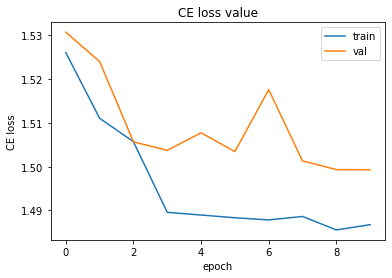

In [ ]:
plt.plot(losses)
plt.plot(losses_eval)
plt.title('CE loss value')
plt.ylabel('CE loss')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper right')
plt.show()

In [ ]:
model_2 = C_LSTM(len(word2id), 300, dropout_emb=True)
optimizer_2 = torch.optim.RMSprop(model_2.parameters(), lr=0.001, weight_decay=0.0001)  # тут регуляризация
criterion = nn.CrossEntropyLoss()

model_2 = model_2.to(DEVICE)
criterion = criterion.to(DEVICE)

losses = []
losses_eval = []
f1s = []
f1s_eval_2 = []


for i in range(10):
    print(f'\nstarting Epoch {i}')
    print('Training...')
    model_2, epoch_loss = train(model_2, train_iterator, optimizer_2, criterion)
    losses.append(epoch_loss)
    print('\nEvaluating on train...')
    f1_on_train,_ = evaluate(model_2, train_iterator, criterion)
    f1s.append(f1_on_train)
    print('\nEvaluating on test...')
    f1_on_test, epoch_loss_on_test = evaluate(model_2, val_iterator, criterion)
    losses_eval.append(epoch_loss_on_test)
    f1s_eval_2.append(f1_on_test)

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:8: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  



starting Epoch 0
Training...
Train loss: 1.5873324159652955
Train loss: 1.5574694547653198
Train loss: 1.5428931992104713
Train loss: 1.5335372662639237
Train loss: 1.530911346909347

Evaluating on train...
Val loss: 1.5384282527431365, Val f1: 0.5483575463294983
Val loss: 1.526732894897461, Val f1: 0.5426791310310364
Val loss: 1.5206572946081771, Val f1: 0.5433559417724609
Val loss: 1.5174878004537635, Val f1: 0.5445032715797424
Val loss: 1.5166965704055348, Val f1: 0.5437809824943542

Evaluating on test...
Val loss: 1.775442103544871, Val f1: 0.6152284145355225
Val loss: 1.6476924144304717, Val f1: 0.558330774307251
Val loss: 1.595320475101471, Val f1: 0.5568478107452393
Val loss: 1.5701615148120456, Val f1: 0.5575821399688721
Val loss: 1.5675512797692244, Val f1: 0.545926034450531

starting Epoch 1
Training...
Train loss: 1.5390874685779694
Train loss: 1.5259508895874023
Train loss: 1.5224630078102679
Train loss: 1.5159804460061974
Train loss: 1.5114379836495515

Evaluating on trai

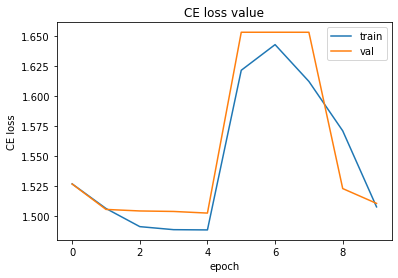

In [ ]:
plt.plot(losses)
plt.plot(losses_eval)
plt.title('CE loss value')
plt.ylabel('CE loss')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper right')
plt.show()

#### Теперь попробуем сделать модель с 2мя свёрточными слоями

In [ ]:
model_3 = C_LSTM(len(word2id), 400, kernel_size_list=[2, 3])
optimizer_3 = torch.optim.RMSprop(model_3.parameters(), lr=0.001, weight_decay=0.0001)  # тут регуляризация
criterion = nn.CrossEntropyLoss()

model_3 = model_3.to(DEVICE)
criterion = criterion.to(DEVICE)

losses = []
losses_eval = []
f1s = []
f1s_eval_3 = []


for i in range(10):
    print(f'\nstarting Epoch {i}')
    print('Training...')
    model_3, epoch_loss = train(model_3, train_iterator, optimizer_3, criterion)
    losses.append(epoch_loss)
    print('\nEvaluating on train...')
    f1_on_train,_ = evaluate(model_3, train_iterator, criterion)
    f1s.append(f1_on_train)
    print('\nEvaluating on test...')
    f1_on_test, epoch_loss_on_test = evaluate(model_3, val_iterator, criterion)
    losses_eval.append(epoch_loss_on_test)
    f1s_eval_3.append(f1_on_test)

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:8: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  



starting Epoch 0
Training...
Train loss: 1.6416284249674888
Train loss: 1.6164714584350586
Train loss: 1.58942781674101
Train loss: 1.565824841123178
Train loss: 1.5446810452801407

Evaluating on train...
Val loss: 1.4780054265452969, Val f1: 0.6078153252601624
Val loss: 1.463443522453308, Val f1: 0.606006920337677
Val loss: 1.4594253859621413, Val f1: 0.6048170924186707
Val loss: 1.4574990324765087, Val f1: 0.6041550636291504
Val loss: 1.454944497081125, Val f1: 0.6048901677131653

Evaluating on test...
Val loss: 1.6825309594472249, Val f1: 0.7128223180770874
Val loss: 1.5592558017143836, Val f1: 0.6519160866737366
Val loss: 1.5227927684783935, Val f1: 0.6342703700065613
Val loss: 1.505626055929396, Val f1: 0.6242502927780151
Val loss: 1.5047155022621155, Val f1: 0.6106013655662537

starting Epoch 1
Training...
Train loss: 1.473155765764175
Train loss: 1.4643622875213622
Train loss: 1.4589021256629457
Train loss: 1.459443790504182
Train loss: 1.4586824212863947

Evaluating on train..

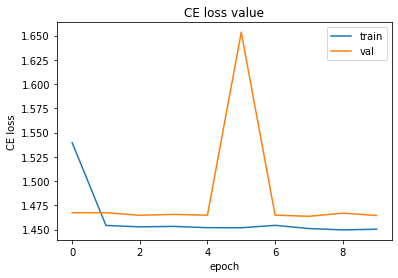

In [ ]:
plt.plot(losses)
plt.plot(losses_eval)
plt.title('CE loss value')
plt.ylabel('CE loss')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper right')
plt.show()

In [ ]:
model_4 = C_LSTM(len(word2id), 400, kernel_size_list=[3, 4])
optimizer_4 = torch.optim.RMSprop(model_4.parameters(), lr=0.001, weight_decay=0.0001)  # тут регуляризация
criterion = nn.CrossEntropyLoss()

model_4 = model_4.to(DEVICE)
criterion = criterion.to(DEVICE)

losses = []
losses_eval = []
f1s = []
f1s_eval_4 = []


for i in range(5):  # чтобы успеть запустить
    print(f'\nstarting Epoch {i}')
    print('Training...')
    model_4, epoch_loss = train(model_4, train_iterator, optimizer_4, criterion)
    losses.append(epoch_loss)
    print('\nEvaluating on train...')
    f1_on_train,_ = evaluate(model_4, train_iterator, criterion)
    f1s.append(f1_on_train)
    print('\nEvaluating on test...')
    f1_on_test, epoch_loss_on_test = evaluate(model_4, val_iterator, criterion)
    losses_eval.append(epoch_loss_on_test)
    f1s_eval_4.append(f1_on_test)

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:8: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  



starting Epoch 0
Training...
Train loss: 1.643917202949524
Train loss: 1.6136997385025025
Train loss: 1.574484663440826
Train loss: 1.5500631265906224
Train loss: 1.5319998063099611

Evaluating on train...
Val loss: 1.4699947064922703, Val f1: 0.6167923808097839
Val loss: 1.4631900234222412, Val f1: 0.606499433517456
Val loss: 1.4576078970381554, Val f1: 0.6061385869979858
Val loss: 1.4568011537491088, Val f1: 0.6042084693908691
Val loss: 1.454471105602896, Val f1: 0.6047813296318054

Evaluating on test...
Val loss: 1.6847409009933472, Val f1: 0.7075521349906921
Val loss: 1.5607112737802358, Val f1: 0.6494836807250977
Val loss: 1.5237803280353546, Val f1: 0.6310957074165344
Val loss: 1.5073493984010484, Val f1: 0.6213012933731079
Val loss: 1.5064146027845495, Val f1: 0.6073331236839294

starting Epoch 1
Training...
Train loss: 1.4711924560608403
Train loss: 1.4692277517318726
Train loss: 1.4625474354054064
Train loss: 1.4628542338709432
Train loss: 1.460076801336495

Evaluating on tra

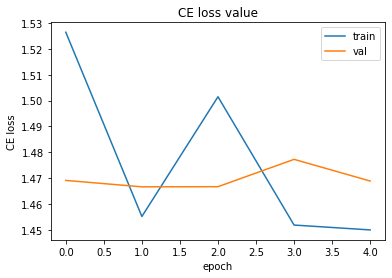

In [ ]:
plt.plot(losses)
plt.plot(losses_eval)
plt.title('CE loss value')
plt.ylabel('CE loss')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper right')
plt.show()

In [ ]:
model_5 = C_LSTM(len(word2id), 400, kernel_size_list=[2, 4])
optimizer_5 = torch.optim.RMSprop(model_5.parameters(), lr=0.001, weight_decay=0.0001)  # тут регуляризация
criterion = nn.CrossEntropyLoss()

model_5 = model_5.to(DEVICE)
criterion = criterion.to(DEVICE)

losses = []
losses_eval = []
f1s = []
f1s_eval_5 = []


for i in range(5):  # чтобы успеть запустить
    print(f'\nstarting Epoch {i}')
    print('Training...')
    model_5, epoch_loss = train(model_5, train_iterator, optimizer_5, criterion)
    losses.append(epoch_loss)
    print('\nEvaluating on train...')
    f1_on_train,_ = evaluate(model_5, train_iterator, criterion)
    f1s.append(f1_on_train)
    print('\nEvaluating on test...')
    f1_on_test, epoch_loss_on_test = evaluate(model_5, val_iterator, criterion)
    losses_eval.append(epoch_loss_on_test)
    f1s_eval_5.append(f1_on_test)

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:8: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  



starting Epoch 0
Training...
Train loss: 1.6486070002278974
Train loss: 1.623585922241211
Train loss: 1.6023966828559308
Train loss: 1.5734427687656356
Train loss: 1.5503098774867452

Evaluating on train...
Val loss: 1.6734099445804473, Val f1: 0.4086087942123413
Val loss: 1.6585246429443359, Val f1: 0.40654557943344116
Val loss: 1.653277562019673, Val f1: 0.4062393009662628
Val loss: 1.6478687771762985, Val f1: 0.4089522957801819
Val loss: 1.6474676975019418, Val f1: 0.4075929522514343

Evaluating on test...
Val loss: 1.93572199344635, Val f1: 0.45215654373168945
Val loss: 1.779645983989422, Val f1: 0.424824059009552
Val loss: 1.720364075899124, Val f1: 0.4295719563961029
Val loss: 1.6929656090559784, Val f1: 0.4309617877006531
Val loss: 1.6938272469183977, Val f1: 0.41493597626686096

starting Epoch 1
Training...
Train loss: 1.5020068153258292
Train loss: 1.475211869239807
Train loss: 1.467106078533416
Train loss: 1.467147014055594
Train loss: 1.464343622231939

Evaluating on train.

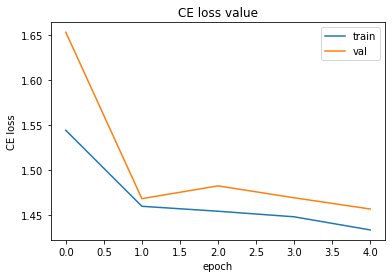

In [ ]:
plt.plot(losses)
plt.plot(losses_eval)
plt.title('CE loss value')
plt.ylabel('CE loss')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper right')
plt.show()

#### Теперь попробуем взять один свёрточный слой с разными размерами шага фильтра

In [ ]:
model_6 = C_LSTM(len(word2id), 400, kernel_size_list=[4])
optimizer_6 = torch.optim.RMSprop(model_6.parameters(), lr=0.001, weight_decay=0.0001)  # тут регуляризация
criterion = nn.CrossEntropyLoss()

model_6 = model_6.to(DEVICE)
criterion = criterion.to(DEVICE)

losses = []
losses_eval = []
f1s = []
f1s_eval_6 = []


for i in range(5):  # чтобы успеть запустить
    print(f'\nstarting Epoch {i}')
    print('Training...')
    model_6, epoch_loss = train(model_6, train_iterator, optimizer_5, criterion)
    losses.append(epoch_loss)
    print('\nEvaluating on train...')
    f1_on_train,_ = evaluate(model_6, train_iterator, criterion)
    f1s.append(f1_on_train)
    print('\nEvaluating on test...')
    f1_on_test, epoch_loss_on_test = evaluate(model_6, val_iterator, criterion)
    losses_eval.append(epoch_loss_on_test)
    f1s_eval_6.append(f1_on_test)

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:8: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  



starting Epoch 0
Training...
Train loss: 1.820368480297827
Train loss: 1.8058840160369873
Train loss: 1.801102193112069
Train loss: 1.7987175035286709
Train loss: 1.7972642046630762

Evaluating on train...
Val loss: 1.8203587397452323, Val f1: 0.16353179514408112
Val loss: 1.8057856731414794, Val f1: 0.16557276248931885
Val loss: 1.800999014935595, Val f1: 0.16262248158454895
Val loss: 1.7986099981216794, Val f1: 0.159427210688591
Val loss: 1.797188902356822, Val f1: 0.1581878960132599

Evaluating on test...
Val loss: 2.0898645917574563, Val f1: 0.20204606652259827
Val loss: 1.929207710119394, Val f1: 0.17587918043136597
Val loss: 1.8810450255870819, Val f1: 0.1717892736196518
Val loss: 1.8578178529386167, Val f1: 0.16797418892383575
Val loss: 1.844177014687482, Val f1: 0.16683445870876312

starting Epoch 1
Training...
Train loss: 1.8205703669978726
Train loss: 1.805985912322998
Train loss: 1.8010704485659903
Train loss: 1.7986424292226237
Train loss: 1.7971756708849767

Evaluating on

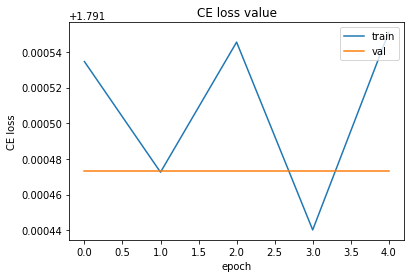

In [ ]:
plt.plot(losses)
plt.plot(losses_eval)
plt.title('CE loss value')
plt.ylabel('CE loss')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper right')
plt.show()

In [ ]:
model_7 = C_LSTM(len(word2id), 400, kernel_size_list=[3])
optimizer_7 = torch.optim.RMSprop(model_7.parameters(), lr=0.001, weight_decay=0.0001)  # тут регуляризация
criterion = nn.CrossEntropyLoss()

model_7 = model_7.to(DEVICE)
criterion = criterion.to(DEVICE)

losses = []
losses_eval = []
f1s = []
f1s_eval_7 = []


for i in range(5):  # чтобы успеть запустить
    print(f'\nstarting Epoch {i}')
    print('Training...')
    model_7, epoch_loss = train(model_7, train_iterator, optimizer_5, criterion)
    losses.append(epoch_loss)
    print('\nEvaluating on train...')
    f1_on_train,_ = evaluate(model_7, train_iterator, criterion)
    f1s.append(f1_on_train)
    print('\nEvaluating on test...')
    f1_on_test, epoch_loss_on_test = evaluate(model_7, val_iterator, criterion)
    losses_eval.append(epoch_loss_on_test)
    f1s_eval_7.append(f1_on_test)

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:8: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  



starting Epoch 0
Training...
Train loss: 1.8159966584174865
Train loss: 1.8018633737564087
Train loss: 1.797163632321865
Train loss: 1.7948593642132216
Train loss: 1.7934513281864726

Evaluating on train...
Val loss: 1.8167212874658647, Val f1: 0.2580379843711853
Val loss: 1.8020154886245727, Val f1: 0.26618629693984985
Val loss: 1.7971347583101152, Val f1: 0.2704479396343231
Val loss: 1.7948051781293406, Val f1: 0.2667491137981415
Val loss: 1.7933532546280295, Val f1: 0.2659066319465637

Evaluating on test...
Val loss: 2.085810979207357, Val f1: 0.32776784896850586
Val loss: 1.9254134801717906, Val f1: 0.285106897354126
Val loss: 1.8774492621421814, Val f1: 0.2662830054759979
Val loss: 1.854387601216634, Val f1: 0.2572101652622223
Val loss: 1.840658633147969, Val f1: 0.2614218592643738

starting Epoch 1
Training...
Train loss: 1.8162474824536232
Train loss: 1.8018648490905762
Train loss: 1.7970841996213223
Train loss: 1.7947845753445568
Train loss: 1.7933641258318713

Evaluating on t

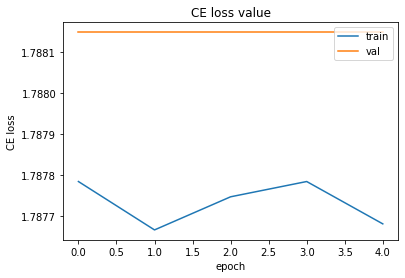

In [ ]:
plt.plot(losses)
plt.plot(losses_eval)
plt.title('CE loss value')
plt.ylabel('CE loss')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper right')
plt.show()

In [ ]:
model_8 = C_LSTM(len(word2id), 400, kernel_size_list=[2])
optimizer_8 = torch.optim.RMSprop(model_8.parameters(), lr=0.001, weight_decay=0.0001)  # тут регуляризация
criterion = nn.CrossEntropyLoss()

model_8 = model_8.to(DEVICE)
criterion = criterion.to(DEVICE)

losses = []
losses_eval = []
f1s = []
f1s_eval_8 = []


for i in range(5):  # чтобы успеть запустить
    print(f'\nstarting Epoch {i}')
    print('Training...')
    model_8, epoch_loss = train(model_8, train_iterator, optimizer_5, criterion)
    losses.append(epoch_loss)
    print('\nEvaluating on train...')
    f1_on_train,_ = evaluate(model_8, train_iterator, criterion)
    f1s.append(f1_on_train)
    print('\nEvaluating on test...')
    f1_on_test, epoch_loss_on_test = evaluate(model_8, val_iterator, criterion)
    losses_eval.append(epoch_loss_on_test)
    f1s_eval_8.append(f1_on_test)

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:8: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  



starting Epoch 0
Training...
Train loss: 1.8194975026192204
Train loss: 1.8047736577987672
Train loss: 1.800089533658738
Train loss: 1.7976734937424679
Train loss: 1.7962058410523043

Evaluating on train...
Val loss: 1.8194316394867436, Val f1: 0.29654112458229065
Val loss: 1.8048572454452514, Val f1: 0.29349398612976074
Val loss: 1.8000741201512358, Val f1: 0.2922838628292084
Val loss: 1.797679827982686, Val f1: 0.2920357882976532
Val loss: 1.796215844002499, Val f1: 0.29395294189453125

Evaluating on test...
Val loss: 2.0888721346855164, Val f1: 0.35063204169273376
Val loss: 1.9283855236493623, Val f1: 0.3078339993953705
Val loss: 1.880265897512436, Val f1: 0.29269346594810486
Val loss: 1.857147287439417, Val f1: 0.281836599111557
Val loss: 1.8434020350961124, Val f1: 0.28629350662231445

starting Epoch 1
Training...
Train loss: 1.819637108233667
Train loss: 1.8047677164077758
Train loss: 1.7999822484686019
Train loss: 1.797457174000987
Train loss: 1.796078756356695

Evaluating on t

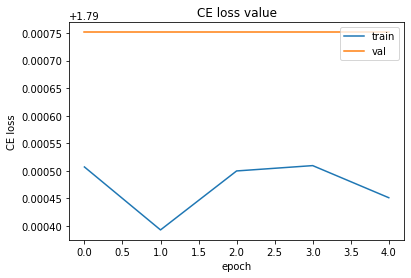

In [ ]:
plt.plot(losses)
plt.plot(losses_eval)
plt.title('CE loss value')
plt.ylabel('CE loss')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper right')
plt.show()

### Что-то вроде итога

В целом, если посмотреть на графики и на значения loss, которые получались в процессе работы моделей, можно сказать, что все модели работают не очень хорошо (плохо). Слишком большое значение loss, плюс периодически встречающиеся взрывы.
Если примерно посмотреть f1 и посмотреть на графики, лучший результат будет у model_5 (2 сверточных слоя, шаги 2 и 4, дропаут после lstm и регуляризация с параметром 0,0001. Но это только номинально, на самом деле, кажется, качество у моделей более менее одинаково.

Кроме того, видимо, я допустила какую-то ошибку при написании самой модели, поскольку в тех случаях, когда модель обучается с одним сверточным слоем, она не обучается совсем - просто как будто каждая эпоха обучается с нуля, каждая эпоха выдает одни и те же числа. Не могу понять, с чем это связано и как с этим справиться, поскольку формально даже не возникает никакой ошибки, просто выдаются одни и те же числа. Да и в целом, если посмотреть на графики, не только моделей с одним сверточным слоем, но и всех остальных, трудно сказать, что модели прям серьезно обучаются.